In [1]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from scipy.linalg import norm
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB



In [2]:
import numpy as np 
ts_msAcc = np.load("testMSAccelerometer.npy")
ts_msGyr = np.load("testMSGyroscope.npy")
ts_labels = np.load("testLabels.npy")

OPEN_DOOR = 20
RUB_HANDS = 36

ts_labels_OPEN_DOOR_idx = ts_labels == OPEN_DOOR
ts_labels_RUB_HANDS_idx = ts_labels == RUB_HANDS

ts_msAcc_OPEN_DOOR = ts_msAcc[ts_labels_OPEN_DOOR_idx]
ts_msGyr_OPEN_DOOR = ts_msGyr[ts_labels_OPEN_DOOR_idx]

ts_msAcc_RUB_HANDS = ts_msAcc[ts_labels_RUB_HANDS_idx]
ts_msGyr_RUB_HANDS = ts_msGyr[ts_labels_RUB_HANDS_idx]

ts_labels_OPEN_DOOR = ts_labels[ts_labels_OPEN_DOOR_idx]
ts_labels_RUB_HANDS = ts_labels[ts_labels_RUB_HANDS_idx]

ts_msAcc_Two_Activities = np.concatenate((ts_msAcc_OPEN_DOOR, ts_msAcc_RUB_HANDS))
ts_msGyr_Two_Activities = np.concatenate((ts_msGyr_OPEN_DOOR, ts_msGyr_RUB_HANDS))
ts_labels_Two_Activities = np.concatenate((ts_labels_OPEN_DOOR, ts_labels_RUB_HANDS))

np.save("test_MSAccelerometer_OpenDoor_RubHands.npy", ts_msAcc_Two_Activities)
np.save("test_MSGyroscope_OpenDoor_RubHands.npy", ts_msGyr_Two_Activities)
np.save("test_labels_OpenDoor_RubHands.npy", ts_labels_Two_Activities)
print(ts_labels_Two_Activities.shape[0])
print(ts_labels_OPEN_DOOR.shape[0])
print(ts_labels_RUB_HANDS.shape[0])

90
48
42


### Extract Train data

In [3]:
import numpy as np 
tr_msAcc = np.load("trainMSAccelerometer.npy")
tr_msGyr = np.load("trainMSGyroscope.npy")
tr_labels = np.load("trainLabels.npy")

OPEN_DOOR = 20
RUB_HANDS = 36

tr_labels_OPEN_DOOR_idx = tr_labels == OPEN_DOOR
tr_labels_RUB_HANDS_idx = tr_labels == RUB_HANDS

tr_msAcc_OPEN_DOOR = tr_msAcc[tr_labels_OPEN_DOOR_idx]
tr_msGyr_OPEN_DOOR = tr_msGyr[tr_labels_OPEN_DOOR_idx]

tr_msAcc_RUB_HANDS = tr_msAcc[tr_labels_RUB_HANDS_idx]
tr_msGyr_RUB_HANDS = tr_msGyr[tr_labels_RUB_HANDS_idx]

tr_labels_OPEN_DOOR = tr_labels[tr_labels_OPEN_DOOR_idx]
tr_labels_RUB_HANDS = tr_labels[tr_labels_RUB_HANDS_idx]

tr_msAcc_Two_Activities = np.concatenate((tr_msAcc_OPEN_DOOR, tr_msAcc_RUB_HANDS))
tr_msGyr_Two_Activities = np.concatenate((tr_msGyr_OPEN_DOOR, tr_msGyr_RUB_HANDS))
tr_labels_Two_Activities = np.concatenate((tr_labels_OPEN_DOOR, tr_labels_RUB_HANDS))

np.save("train_MSAccelerometer_OpenDoor_RubHands.npy", tr_msAcc_Two_Activities)
np.save("train_MSGyroscope_OpenDoor_RubHands.npy", tr_msGyr_Two_Activities)
np.save("train_labels_OpenDoor_RubHands.npy", tr_labels_Two_Activities)
print(tr_labels_Two_Activities.shape[0])

87


### compute features

In [4]:
 

def compute_features(data,tr_msAcc_Two_Activities):
    for i in range(tr_msAcc_Two_Activities.shape[0]):
        # Initialize an empty list to hold statistics for this sample
        stats = []
    
        # Maximum
        stats.append(np.max(tr_msAcc_Two_Activities[i], axis = 0))
    
        # Minimum
        stats.append(np.min(tr_msAcc_Two_Activities[i], axis = 0))
    
        # First-order mean
        mean_val = np.mean(tr_msAcc_Two_Activities[i], axis = 0)
        stats.append(mean_val)
    
        # Standard Deviation
        stats.append(np.std(tr_msAcc_Two_Activities[i], axis = 0))
    
        # Percentile 50
        stats.append(np.percentile(tr_msAcc_Two_Activities[i], 50, axis = 0))
    
        # Percentile 80
        stats.append(np.percentile(tr_msAcc_Two_Activities[i], 80, axis = 0))
    
        # Norm of the first-order mean
        stats.append(np.full(mean_val.shape, norm(mean_val)))
    
        # Average (same as mean)
        stats.append(mean_val)
    
        # Interquartile range
        stats.append(np.percentile(tr_msAcc_Two_Activities[i], 75, axis = 0) - np.percentile(tr_msAcc_Two_Activities[i], 25, axis = 0))
    
        # Second-order mean
        squared_mean = np.mean(np.square(tr_msAcc_Two_Activities[i]), axis = 0)
        stats.append(squared_mean)
    
        # Skewness
        stats.append(skew(tr_msAcc_Two_Activities[i], axis = 0))
    
        # Norm of the second-order mean
        stats.append(np.full(squared_mean.shape, norm(squared_mean)))
    
        # Zero-crossing
        zero_crossings = np.sum(np.diff(np.sign(tr_msAcc_Two_Activities[i]), axis = 0) != 0, axis = 0)
        stats.append(zero_crossings)
    
        # Kurtosis
        stats.append(kurtosis(tr_msAcc_Two_Activities[i], axis = 0))
    
        # Spectral energy
        frequencies, power_spectral_density = welch(tr_msAcc_Two_Activities[i], axis = 0)
        spectral_energy = np.sum(power_spectral_density, axis = 0)
        stats.append(spectral_energy)
    
        # Percentile 20
        stats.append(np.percentile(tr_msAcc_Two_Activities[i], 20, axis = 0))
    
        # Auto-correlation (assuming lag 1)
        autocorr = np.array([acf(tr_msAcc_Two_Activities[i][:, j], nlags = 1, fft = True)[1] for j in range(tr_msAcc_Two_Activities[i].shape[1])])
        stats.append(autocorr)
    
        # Spectral entropy
        power_spectral_density /= np.sum(power_spectral_density, axis = 0, keepdims = True)
        spectral_entropy = entropy(power_spectral_density, axis = 0)
        stats.append(spectral_entropy)
    
        # Convert list of arrays to a 2D array of shape (18, 3)
        stats_array = np.array(stats)
    
        # Store in pre-allocated data array
        data[i] = stats_array
    
    # Now `data` contains the computed statistics for each sample


### Training Data reshape and concatenate

In [5]:
data = np.empty((tr_msAcc_Two_Activities.shape[0], 18, 3))
compute_features(data,tr_msAcc_Two_Activities)
# reshape the data so that each row contain all features of the one example(x-axis,y-axis,z-axis)
data = np.reshape(data,(tr_msAcc_Two_Activities.shape[0],1,-1))
print(data.shape)
tr_msAcc_Two_Activities = data

(87, 1, 54)


In [6]:
data = np.empty((tr_msGyr_Two_Activities.shape[0], 18, 3))
compute_features(data,tr_msGyr_Two_Activities)
data = np.reshape(data,(tr_msGyr_Two_Activities.shape[0],1,-1))
print(data.shape)
tr_msGyr_Two_Activities = data

(87, 1, 54)


In [7]:
train_data = np.concatenate((tr_msAcc_Two_Activities, tr_msGyr_Two_Activities), axis=2)
train_labels = tr_labels_Two_Activities

train_data = np.squeeze(train_data, axis=1)
train_labels = train_labels[:, np.newaxis]


for i in range(train_data.shape[0]):
    if train_labels[i] == 20:
        train_labels[i] = 0;
    elif train_labels[i] == 36:
        train_labels[i] = 1;


### Test Data reshape and concatenate

In [8]:
data = np.empty((ts_msAcc_Two_Activities.shape[0], 18, 3))
compute_features(data,ts_msAcc_Two_Activities)
# reshape the data so that each row contain all features of the one example(x-axis,y-axis,z-axis)
data = np.reshape(data,(ts_msAcc_Two_Activities.shape[0],1,-1))
data[0,0,:]
print(data.shape)
ts_msAcc_Two_Activities = data

(90, 1, 54)


In [9]:
data = np.empty((ts_msGyr_Two_Activities.shape[0], 18, 3))
compute_features(data,ts_msGyr_Two_Activities)
data = np.reshape(data,(ts_msGyr_Two_Activities.shape[0],1,-1))
data[0,0,:]
print(data.shape)
ts_msGyr_Two_Activities = data

(90, 1, 54)


In [10]:
test_data = np.concatenate((ts_msAcc_Two_Activities, ts_msGyr_Two_Activities), axis = 2)
test_labels = ts_labels_Two_Activities

test_data = np.squeeze(test_data, axis = 1)
test_labels = test_labels[:, np.newaxis]

for i in range(test_data.shape[0]):
    if test_labels[i] == 20:
        test_labels[i] = 0;
    elif test_labels[i] == 36:
        test_labels[i] = 1;


In [11]:
model = LogisticRegression();

In [12]:
model.fit(train_data,train_labels)

C:\Users\inzi4\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\inzi4\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [13]:
y_prediction = model.predict(test_data)

In [14]:
accuracy = accuracy_score(test_labels,y_prediction)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.96


In [15]:
confusion_matrix = confusion_matrix(test_labels,y_prediction)
print(confusion_matrix)

[[46  2]
 [ 2 40]]


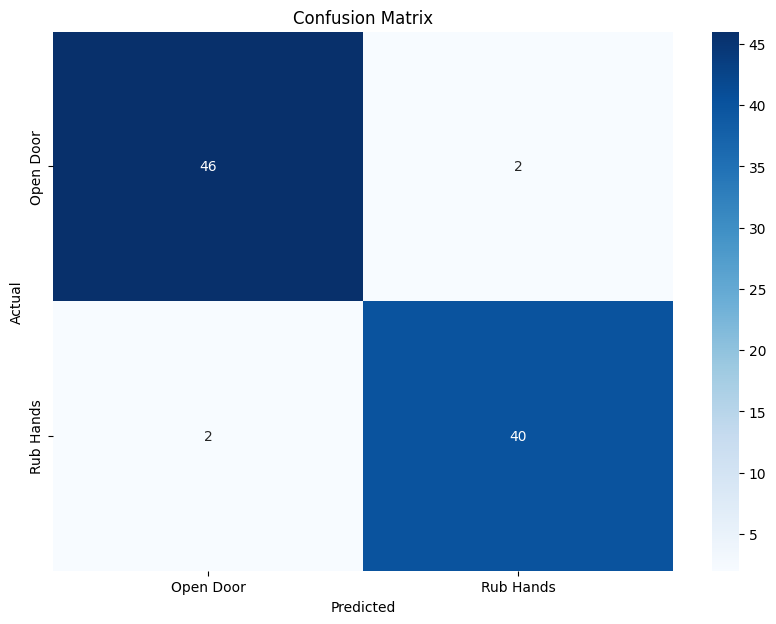

Weighted F1 Score: 0.96
Classification Report:
              precision    recall  f1-score   support

   Open Door       0.96      0.96      0.96        48
   Rub Hands       0.95      0.95      0.95        42

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



In [16]:



# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Open Door', 'Rub Hands'], yticklabels=['Open Door', 'Rub Hands'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# F1 Score and Classification Report
f1 = f1_score(test_labels, y_prediction, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')
print('Classification Report:')
print(classification_report(test_labels, y_prediction, target_names=['Open Door', 'Rub Hands']))



### Use Our Logistic Regression Model

In [24]:
# # Importing libraries 
# import numpy as np 
# import pandas as pd 
# from sklearn.model_selection import train_test_split 
# import warnings 
# warnings.filterwarnings( "ignore" ) 

# # to compare our model's accuracy with sklearn model 
# from sklearn.linear_model import LogisticRegression 
# # Logistic Regression 
# class LogitRegression() : 
#     def __init__( self, learning_rate, iterations,lambda_param ) : 
#         self.learning_rate = learning_rate 
#         self.iterations = iterations 
#         self.lambda_param=lambda_param




#     def fit( self, X, Y ) :
#         # no_of_training_examples, no_of_features
#         self.m, self.n = X.shape
#         # weight initialization
#         self.W = np.zeros( self.n ) 
#         self.b = 0
#         self.X = X 
#         self.Y = Y
#         # gradient descent learning 
#         for i in range( self.iterations ) :
#             self.update_weights() 
#         return self

    

    

# #Helper function to update weights in gradient descent 

#     def update_weights( self ) :		 
#         A = 1 / ( 1 + np.exp( - ( self.X.dot( self.W ) + self.b ) ) ) 

#         # calculate gradients		 
#         tmp = ( A - self.Y.T )		 
#         #it is converting 2-D array to 1-D array
#         tmp = np.reshape( tmp, self.m )		 

#         dW = np.dot( self.X.T, tmp ) / self.m
#         db = np.sum( tmp ) / self.m 

#         # update weights	 
       
#         self.W = self.W * (1 - self.learning_rate * self.lambda_param/self.m) - self.learning_rate * dW
#         self.b = self.b - self.learning_rate * db 

#         return self




# # Hypothetical function h( x ) 

#     def predict( self, X ) :
#         Z = 1 / ( 1 + np.exp( - ( X.dot( self.W ) ) ) )
#         Y = np.where( Z > 0.5, 1, 0 )
#         return Y 


# # Driver code 

# def main() : 

   

#     # Model training 
#     model = LogitRegression( learning_rate = 0.01, iterations = 1000,lambda_param=1000) 

#     model.fit( train_data,train_labels ) 
# #     model1 = LogisticRegression() 
# #     model1.fit( X_train, Y_train) 

#     # Prediction on test set 
#     Y_pred = model.predict( test_data )
    
    

#     accuracy = accuracy_score(test_labels,Y_pred)

#     print(f'Accuracy: {accuracy:.2f}')

    


# if __name__ == "__main__" :	 
# 	main()
